# Preferences

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchsummary import summary
from torchviz import make_dot
print(torch.__version__)

import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from IPython.display import Image

2.3.1


In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

if torch.cuda.is_available():
    print("Available GPUs:", torch.cuda.device_count())
    for i in range(torch.cuda.device_count()):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
else:
    print("No GPUs available, CPU {} ".format(device))

Available GPUs: 1
GPU 0: NVIDIA GeForce GTX 1080


# Data Preprocessing

def my_DataLoader(train_root,test_root,batch_size = 100, val_split_factor = 0.2):

    train_df = pd.read_csv(train_root, header=None)
    test_df = pd.read_csv(test_root, header=None)

    train_data = train_df.to_numpy()
    test_data = test_df.to_numpy()

    train_dataset = torch.utils.data.TensorDataset(torch.from_numpy(train_data[:, :-1]).float(),
                                                   torch.from_numpy(train_data[:, -1]).long(),)
    test_dataset = torch.utils.data.TensorDataset(torch.from_numpy(test_data[:, :-1]).float(),
                                                  torch.from_numpy(test_data[:, -1]).long())

    train_len = train_data.shape[0]
    val_len = int(train_len * val_split_factor)
    train_len -= val_len

    train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_len, val_len])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

    return train_loader, val_loader, test_loader

In [3]:
train_pd = pd.read_csv("/home/hanaesori/workspace/jupyter_notebook/Neural_Network/csv/mitbih_train.csv", header=None)
train_pd.head()

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,0.977941,0.926471,0.681373,0.245098,0.154412,0.191176,0.151961,0.085784,0.058824,0.049020,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.960114,0.863248,0.461538,0.196581,0.094017,0.125356,0.099715,0.088319,0.074074,0.082621,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.000000,0.659459,0.186486,0.070270,0.070270,0.059459,0.056757,0.043243,0.054054,0.045946,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.925414,0.665746,0.541436,0.276243,0.196133,0.077348,0.071823,0.060773,0.066298,0.058011,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.967136,1.000000,0.830986,0.586854,0.356808,0.248826,0.145540,0.089202,0.117371,0.150235,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
train_np = train_pd.to_numpy()
train_data = torch.utils.data.TensorDataset(torch.from_numpy(train_np[:, :-1]).float(), torch.from_numpy(train_np[:, -1]).long(),)
train_loader = DataLoader(train_data, batch_size=1000, shuffle=True)

X_train = train_data.tensors[0]
Y_train = train_data.tensors[1]

print('Data Set(Sample, Features) :', len(train_data), X_train.shape[1]) #=> X shape : (87553, 187)
print('Number of Categories :', len(Y_train.unique()))
print('Classes[Normal = 0, Supra-ventricular = 1, Ventricular escape = 2, Fusion of ventricular = 3, Unclassifiable = 4] :')
for i in range(len(Y_train.unique())):
    print(f'Label {Y_train.unique()[i].item()} count: {torch.sum(Y_train == Y_train.unique()[i])}')

Data Set(Sample, Features) : 87554 187
Number of Categories : 5
Classes[Normal = 0, Supra-ventricular = 1, Ventricular escape = 2, Fusion of ventricular = 3, Unclassifiable = 4] :
Label 0 count: 72471
Label 1 count: 2223
Label 2 count: 5788
Label 3 count: 641
Label 4 count: 6431


In [5]:
val_split_factor = 0.2
batch_size = 100

train_len = train_np.shape[0]
val_len = int(train_len * val_split_factor)
train_len -= val_len

train_data, val_data = torch.utils.data.random_split(train_data, [train_len, val_len])
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True)

x_train, x_test, y_train, y_test = train_test_split(X,Y,test_size=0.2,random_state=7, stratify=Y)
print('Train shape :',x_train.shape) #=> Train shape : (3998, 140)
print('Test shape :',x_test.shape) #=> Test shape : (1000, 140)

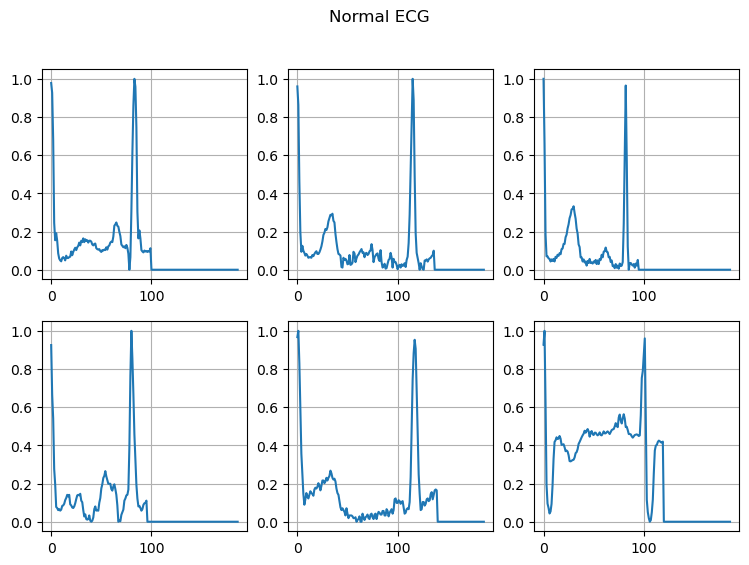

In [6]:
normal_X_train = X_train[Y_train == 0]

fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(9,6))
fig.suptitle("Normal ECG")
ax = ax.ravel()
for idx, ax in enumerate(ax):
    ax.grid()
    ax.plot(np.arange(len(normal_X_train[idx])), normal_X_train[idx])
plt.show()

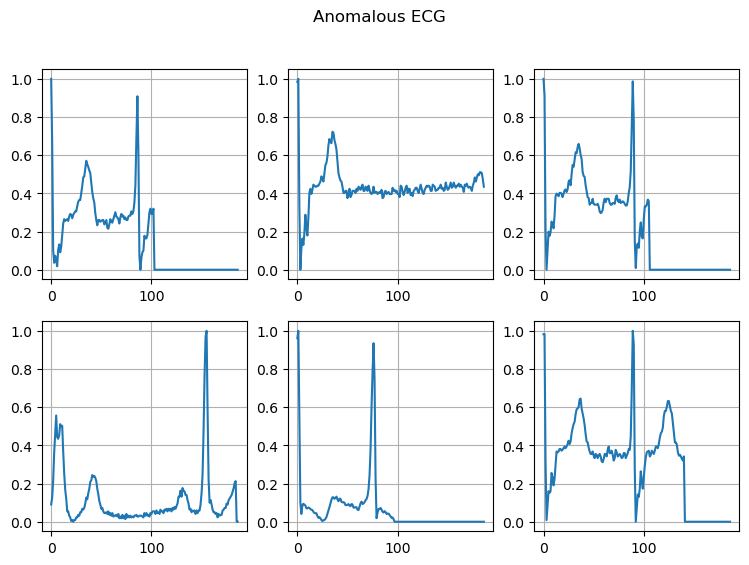

In [7]:
anomalous_X_train = X_train[Y_train!=0]

fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(9,6))
fig.suptitle("Anomalous ECG")
ax = ax.ravel()
for idx, ax in enumerate(ax):
    ax.grid()
    ax.plot(np.arange(len(anomalous_X_train[idx])), anomalous_X_train[idx])
plt.show()

# 1D-CNN Modeling

In [8]:
class ConvNet1D(nn.Module):
    def __init__(self, num_of_class):
        super(ConvNet1D, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv1d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.MaxPool1d(2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv1d(16, 64, kernel_size=3, stride=1, padding=1),
            nn.MaxPool1d(2)
        )
        self.layer3 = nn.Sequential(
            nn.Conv1d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.MaxPool1d(2)
        )
        self.fc = nn.Sequential(
            nn.Linear(2944,500),
            nn.LeakyReLU(inplace=True),
            nn.Linear(500, num_of_class),
        )

    def forward(self,x):
        if x.dim() == 2:  # [batch_size, length]
            x = x.unsqueeze(1)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        # print(x.shape)
        x = x.view(x.size(0), -1)
        #x [b, 2944]
        # print(x.shape)
        x = self.fc(x)

        return x

class ConvNet1D(nn.Module):
    def __init__(self):
        super(ConvNet1D, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv1d(1, 36, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm1d(36),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=5, stride=2, padding=0)
        )
        self.layer2 = nn.Sequential(
            nn.Conv1d(36, 48, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm1d(48),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=5, stride=2, padding=0)
        )
        self.layer3 = nn.Sequential(
            nn.Conv1d(48, 64, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=5, stride=2, padding=0)
        )
        self.fc = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(1280, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(64, 5)
        )

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

# define the model using pytorch
class ConvNet1D(nn.Module):
    def __init__(self, conv_dim):
        super(ConvNet1D, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv1d(in_channels=3,
                      out_channels=conv_dim,
                      kernel_size=4,
                      stride=1,
                      padding=0,
                      dilation=1,
                      groups=1,
                      bias=True,
                      padding_mode='zeros'), 
            nn.BatchNorm1d(num_features, 
                           eps=1e-05, 
                           momentum=0.1, 
                           affine=True, 
                           track_running_stats=True), 
            nn.ReLU(inplace=False), 
            nn.MaxPool1d(kernel_size=2, 
                         stride=2, 
                         padding=0,
                         dilation=1,
                         ceil_mode=False)
        )
            
        self.layer2 = nn.Sequential(
            nn.Conv1d(in_channels=3,
                      out_channels=conv_dim,
                      kernel_size=4,
                      stride=1,
                      padding=0,
                      dilation=1,
                      groups=1,
                      bias=True,
                      padding_mode='zeros'), 
            nn.BatchNorm1d(num_features, 
                           eps=1e-05, 
                           momentum=0.1, 
                           affine=True, 
                           track_running_stats=True), 
            nn.ReLU(inplace=False), 
            nn.MaxPool1d(kernel_size=2, 
                         stride=2, 
                         padding=0,
                         dilation=1,
                         ceil_mode=False)
        )
            
        self.layer3 = nn.Sequential(
            nn.Conv1d(in_channels=3,
                      out_channels=conv_dim,
                      kernel_size=4,
                      stride=1,
                      padding=0,
                      dilation=1,
                      groups=1,
                      bias=True,
                      padding_mode='zeros'), 
            nn.BatchNorm1d(num_features, 
                           eps=1e-05, 
                           momentum=0.1, 
                           affine=True, 
                           track_running_stats=True), 
            nn.ReLU(inplace=False), 
            nn.MaxPool1d(kernel_size=2, 
                         stride=2, 
                         padding=0,
                         dilation=1,
                         ceil_mode=False)
        )
            
        self.fc = nn.Sequential(
            nn.Dropout(p=drop_prob), 
            nn.Linear(in_features=10,
                      out_features=20,
                      bias=True), 
            nn.BatchNorm1d(num_features, 
                           eps=1e-05, 
                           momentum=0.1, 
                           affine=True, 
                           track_running_stats=True), 
            nn.ReLU(inplace=False), 
            nn.Dropout(p=drop_prob), 
            nn.Linear(in_features=10,
                      out_features=20,
                      bias=True), 
            nn.BatchNorm1d(num_features, 
                           eps=1e-05, 
                           momentum=0.1, 
                           affine=True, 
                           track_running_stats=True), 
            nn.ReLU(inplace=False), 
            nn.Dropout(p=drop_prob), 
            nn.Linear(in_features=10,
                      out_features=20,
                      bias=True)
        )

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = F.relu(self.layer3(x))
            
        # Flatten
        x = x.view(-1, self.conv_dim*4*4*4)
        out = self.fc(x)
            
        return out 

In [9]:
def evalute(model, loader, crit):
    model.eval()

    correct = 0
    total = len(loader.dataset)
    val_bar = tqdm(loader, file=sys.stdout)
    cur_loss=[]
    for x, y in val_bar:
        x, y = x.to(device), y.to(device)
        with torch.no_grad():
            logits = model(x)
            pred = logits.argmax(dim=1)
            cur_loss.append(crit(logits, y))
        correct += torch.eq(pred, y).sum().float().item()

    return correct / total, sum(cur_loss)/len(cur_loss)

In [10]:
model = ConvNet1D(len(Y_train.unique())).to(device)
compiled_model = torch.compile(model).cuda

# Model Learning

In [11]:
batch_size = 100
lr = 3e-3
epochs = 70
torch.manual_seed(1234)
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

In [12]:
best_acc, best_epoch = 0, 0
global_step = 0
train_acc=[]
train_loss=[]
val_acc=[]
val_loss=[]
for epoch in range(epochs):
    correct=0
    train_bar = tqdm(train_loader, file=sys.stdout)
    for step, (x, y) in enumerate(train_bar):
        # x: [b, 187], y: [b]
        x, y = x.to(device), y.to(device)
        model.train()
        logits = model(x)
        loss = criterion(logits, y)
        preds=logits.argmax(dim=1)
        correct+=torch.eq(preds, y).sum().float().item()
        optimizer.zero_grad()
        loss.backward()
        
        # for param in model.parameters():
        #     print(param.grad)
        optimizer.step()
        
        train_bar.desc = "train epoch[{}/{}] loss:{:.3f}".format(epoch + 1,
                                                                 epochs,
                                                                 loss)
        global_step += 1
    train_loss.append(loss)
    train_acc.append(correct/len(train_loader.dataset))
    print('Train Acc: {}'.format(correct/len(train_loader.dataset)))
    if epoch % 1 == 0:  # You can change the validation frequency as you wish
        val_acc_epo, val_loss_epo = evalute(model, val_loader, criterion)
        val_acc.append(val_acc_epo)
        val_loss.append(val_loss_epo)
        print('val_acc = ',val_acc_epo)
        if val_acc_epo > best_acc:
            best_epoch = epoch
            best_acc = val_acc_epo
            #torch.save(model, '1DCNN.pt')
            torch.save(model.state_dict(), '1DCNN.mdl')
            #torch.save(model.state_dict(), '1DCNN_weights.pt')
print('best acc:', best_acc, 'best epoch:', best_epoch)
model.load_state_dict(torch.load('1DCNN.mdl'))
print('loaded from ckpt!')

  0%|          | 0/88 [00:00<?, ?it/s]

Train Acc: 0.889690933595267


  0%|          | 0/176 [00:00<?, ?it/s]

val_acc =  0.956996002284409


  0%|          | 0/88 [00:00<?, ?it/s]

Train Acc: 0.9615208899650501


  0%|          | 0/176 [00:00<?, ?it/s]

val_acc =  0.9700171330668189


  0%|          | 0/88 [00:00<?, ?it/s]

Train Acc: 0.9720515339105009


  0%|          | 0/176 [00:00<?, ?it/s]

val_acc =  0.9741290691033695


  0%|          | 0/88 [00:00<?, ?it/s]

Train Acc: 0.9754437261575714


  0%|          | 0/176 [00:00<?, ?it/s]

val_acc =  0.980411193603655


  0%|          | 0/88 [00:00<?, ?it/s]

Train Acc: 0.9793384654042077


  0%|          | 0/176 [00:00<?, ?it/s]

val_acc =  0.9817818389491719


  0%|          | 0/88 [00:00<?, ?it/s]

Train Acc: 0.9808917924937752


  0%|          | 0/176 [00:00<?, ?it/s]

val_acc =  0.9841233580810965


  0%|          | 0/88 [00:00<?, ?it/s]

Train Acc: 0.9829362450601914


  0%|          | 0/176 [00:00<?, ?it/s]

val_acc =  0.9849800114220445


  0%|          | 0/88 [00:00<?, ?it/s]

Train Acc: 0.9841583479909541


  0%|          | 0/176 [00:00<?, ?it/s]

val_acc =  0.9868075385494004


  0%|          | 0/88 [00:00<?, ?it/s]

Train Acc: 0.985803047262261


  0%|          | 0/176 [00:00<?, ?it/s]

val_acc =  0.9886350656767562


  0%|          | 0/88 [00:00<?, ?it/s]

Train Acc: 0.9866596614660667


  0%|          | 0/176 [00:00<?, ?it/s]

val_acc =  0.9892061679040548


  0%|          | 0/88 [00:00<?, ?it/s]

Train Acc: 0.9877218630787856


  0%|          | 0/176 [00:00<?, ?it/s]

val_acc =  0.9908052541404911


  0%|          | 0/88 [00:00<?, ?it/s]

Train Acc: 0.9888868583959614


  0%|          | 0/176 [00:00<?, ?it/s]

val_acc =  0.9904054825813821


  0%|          | 0/88 [00:00<?, ?it/s]

Train Acc: 0.9895150421454189


  0%|          | 0/176 [00:00<?, ?it/s]

val_acc =  0.990005711022273


  0%|          | 0/88 [00:00<?, ?it/s]

Train Acc: 0.9908170957352034


  0%|          | 0/176 [00:00<?, ?it/s]

val_acc =  0.9933181039406054


  0%|          | 0/88 [00:00<?, ?it/s]

Train Acc: 0.9909655755305298


  0%|          | 0/176 [00:00<?, ?it/s]

val_acc =  0.9931467732724157


  0%|          | 0/88 [00:00<?, ?it/s]

Train Acc: 0.9923361582566188


  0%|          | 0/176 [00:00<?, ?it/s]

val_acc =  0.991776127926899


  0%|          | 0/88 [00:00<?, ?it/s]

Train Acc: 0.992176256938575


  0%|          | 0/176 [00:00<?, ?it/s]

val_acc =  0.9935465448315248


  0%|          | 0/88 [00:00<?, ?it/s]

Train Acc: 0.9919478264842269


  0%|          | 0/176 [00:00<?, ?it/s]

val_acc =  0.9936036550542547


  0%|          | 0/88 [00:00<?, ?it/s]

Train Acc: 0.9930785572332503


  0%|          | 0/176 [00:00<?, ?it/s]

val_acc =  0.9936607652769845


  0%|          | 0/88 [00:00<?, ?it/s]

Train Acc: 0.9936153688009686


  0%|          | 0/176 [00:00<?, ?it/s]

val_acc =  0.9936607652769845


  0%|          | 0/88 [00:00<?, ?it/s]

Train Acc: 0.991810768211618


  0%|          | 0/176 [00:00<?, ?it/s]

val_acc =  0.9930896630496859


  0%|          | 0/88 [00:00<?, ?it/s]

Train Acc: 0.9925303241428147


  0%|          | 0/176 [00:00<?, ?it/s]

val_acc =  0.9947458595088521


  0%|          | 0/88 [00:00<?, ?it/s]

Train Acc: 0.9941521803686868


  0%|          | 0/176 [00:00<?, ?it/s]

val_acc =  0.9936607652769845


  0%|          | 0/88 [00:00<?, ?it/s]

Train Acc: 0.9943463462548827


  0%|          | 0/176 [00:00<?, ?it/s]

val_acc =  0.9962878355225585


  0%|          | 0/88 [00:00<?, ?it/s]

Train Acc: 0.9951458528451013


  0%|          | 0/176 [00:00<?, ?it/s]

val_acc =  0.9952598515134209


  0%|          | 0/88 [00:00<?, ?it/s]

Train Acc: 0.9957283505036891


  0%|          | 0/176 [00:00<?, ?it/s]

val_acc =  0.9944031981724729


  0%|          | 0/88 [00:00<?, ?it/s]

Train Acc: 0.9946204628001005


  0%|          | 0/176 [00:00<?, ?it/s]

val_acc =  0.9954882924043403


  0%|          | 0/88 [00:00<?, ?it/s]

Train Acc: 0.994997373049775


  0%|          | 0/176 [00:00<?, ?it/s]

val_acc =  0.9959451741861793


  0%|          | 0/88 [00:00<?, ?it/s]

Train Acc: 0.995248646549558


  0%|          | 0/176 [00:00<?, ?it/s]

val_acc =  0.9965733866362079


  0%|          | 0/88 [00:00<?, ?it/s]

Train Acc: 0.9957283505036891


  0%|          | 0/176 [00:00<?, ?it/s]

val_acc =  0.9974871501998858


  0%|          | 0/88 [00:00<?, ?it/s]

Train Acc: 0.9960824177079288


  0%|          | 0/176 [00:00<?, ?it/s]

val_acc =  0.9966304968589378


  0%|          | 0/88 [00:00<?, ?it/s]

Train Acc: 0.9966534938437993


  0%|          | 0/176 [00:00<?, ?it/s]

val_acc =  0.9972015990862364


  0%|          | 0/88 [00:00<?, ?it/s]

Train Acc: 0.9968933458208649


  0%|          | 0/176 [00:00<?, ?it/s]

val_acc =  0.9963449457452884


  0%|          | 0/88 [00:00<?, ?it/s]

Train Acc: 0.9965735431847774


  0%|          | 0/176 [00:00<?, ?it/s]

val_acc =  0.996916047972587


  0%|          | 0/88 [00:00<?, ?it/s]

Train Acc: 0.996813395161843


  0%|          | 0/176 [00:00<?, ?it/s]

val_acc =  0.9967447173043975


  0%|          | 0/88 [00:00<?, ?it/s]

Train Acc: 0.9961166822760811


  0%|          | 0/176 [00:00<?, ?it/s]

val_acc =  0.9968589377498572


  0%|          | 0/88 [00:00<?, ?it/s]

Train Acc: 0.996367955775864


  0%|          | 0/176 [00:00<?, ?it/s]

val_acc =  0.9970302684180469


  0%|          | 0/88 [00:00<?, ?it/s]

Train Acc: 0.9955456061402106


  0%|          | 0/176 [00:00<?, ?it/s]

val_acc =  0.9960022844089091


  0%|          | 0/88 [00:00<?, ?it/s]

Train Acc: 0.995362861776732


  0%|          | 0/176 [00:00<?, ?it/s]

val_acc =  0.9963449457452884


  0%|          | 0/88 [00:00<?, ?it/s]

Train Acc: 0.9967905521164082


  0%|          | 0/176 [00:00<?, ?it/s]

val_acc =  0.9970302684180469


  0%|          | 0/88 [00:00<?, ?it/s]

Train Acc: 0.9971331977979304


  0%|          | 0/176 [00:00<?, ?it/s]

val_acc =  0.9974871501998858


  0%|          | 0/88 [00:00<?, ?it/s]

Train Acc: 0.9970075610480389


  0%|          | 0/176 [00:00<?, ?it/s]

val_acc =  0.9975442604226157


  0%|          | 0/88 [00:00<?, ?it/s]

Train Acc: 0.9972930991159742


  0%|          | 0/176 [00:00<?, ?it/s]

val_acc =  0.9958880639634494


  0%|          | 0/88 [00:00<?, ?it/s]

Train Acc: 0.9978299106836923


  0%|          | 0/176 [00:00<?, ?it/s]

val_acc =  0.9977727013135351


  0%|          | 0/88 [00:00<?, ?it/s]

Train Acc: 0.9979555474335838


  0%|          | 0/176 [00:00<?, ?it/s]

val_acc =  0.9988006853226727


  0%|          | 0/88 [00:00<?, ?it/s]

Train Acc: 0.9980126550471708


  0%|          | 0/176 [00:00<?, ?it/s]

val_acc =  0.9977727013135351


  0%|          | 0/88 [00:00<?, ?it/s]

Train Acc: 0.9981497133197798


  0%|          | 0/176 [00:00<?, ?it/s]

val_acc =  0.9972587093089663


  0%|          | 0/88 [00:00<?, ?it/s]

Train Acc: 0.9976129017520616


  0%|          | 0/176 [00:00<?, ?it/s]

val_acc =  0.9958309537407196


  0%|          | 0/88 [00:00<?, ?it/s]

Train Acc: 0.9968362382072778


  0%|          | 0/176 [00:00<?, ?it/s]

val_acc =  0.9970873786407767


  0%|          | 0/88 [00:00<?, ?it/s]

Train Acc: 0.9963565342531466


  0%|          | 0/176 [00:00<?, ?it/s]

val_acc =  0.9963449457452884


  0%|          | 0/88 [00:00<?, ?it/s]

Train Acc: 0.9974187358658656


  0%|          | 0/176 [00:00<?, ?it/s]

val_acc =  0.9977155910908052


  0%|          | 0/88 [00:00<?, ?it/s]

Train Acc: 0.9962080544578203


  0%|          | 0/176 [00:00<?, ?it/s]

val_acc =  0.9950314106225014


  0%|          | 0/88 [00:00<?, ?it/s]

Train Acc: 0.9969161888662996


  0%|          | 0/176 [00:00<?, ?it/s]

val_acc =  0.9983438035408339


  0%|          | 0/88 [00:00<?, ?it/s]

Train Acc: 0.9976129017520616


  0%|          | 0/176 [00:00<?, ?it/s]

val_acc =  0.9974871501998858


  0%|          | 0/88 [00:00<?, ?it/s]

Train Acc: 0.9974644219567352


  0%|          | 0/176 [00:00<?, ?it/s]

val_acc =  0.9981153626499143


  0%|          | 0/88 [00:00<?, ?it/s]

Train Acc: 0.9982753500696713


  0%|          | 0/176 [00:00<?, ?it/s]

val_acc =  0.9985151342090234


  0%|          | 0/88 [00:00<?, ?it/s]

Train Acc: 0.9984238298649976


  0%|          | 0/176 [00:00<?, ?it/s]

val_acc =  0.9990291262135922


  0%|          | 0/88 [00:00<?, ?it/s]

Train Acc: 0.9984124083422802


  0%|          | 0/176 [00:00<?, ?it/s]

val_acc =  0.9992004568817818


  0%|          | 0/88 [00:00<?, ?it/s]

Train Acc: 0.998572309660324


  0%|          | 0/176 [00:00<?, ?it/s]

val_acc =  0.9990862364363221


  0%|          | 0/88 [00:00<?, ?it/s]

Train Acc: 0.9975557941384745


  0%|          | 0/176 [00:00<?, ?it/s]

val_acc =  0.9971444888635066


  0%|          | 0/88 [00:00<?, ?it/s]

Train Acc: 0.9962880051168421


  0%|          | 0/176 [00:00<?, ?it/s]

val_acc =  0.9957738435179897


  0%|          | 0/88 [00:00<?, ?it/s]

Train Acc: 0.9974073143431482


  0%|          | 0/176 [00:00<?, ?it/s]

val_acc =  0.9975442604226157


  0%|          | 0/88 [00:00<?, ?it/s]

Train Acc: 0.9978413322064098


  0%|          | 0/176 [00:00<?, ?it/s]

val_acc =  0.9984580239862936


  0%|          | 0/88 [00:00<?, ?it/s]

Train Acc: 0.9980469196153231


  0%|          | 0/176 [00:00<?, ?it/s]

val_acc =  0.9981153626499143


  0%|          | 0/88 [00:00<?, ?it/s]

Train Acc: 0.998183977887932


  0%|          | 0/176 [00:00<?, ?it/s]

val_acc =  0.9987435750999429


  0%|          | 0/88 [00:00<?, ?it/s]

Train Acc: 0.998435251387715


  0%|          | 0/176 [00:00<?, ?it/s]

val_acc =  0.9987435750999429


  0%|          | 0/88 [00:00<?, ?it/s]

Train Acc: 0.9981382917970624


  0%|          | 0/176 [00:00<?, ?it/s]

val_acc =  0.9956025128498002


  0%|          | 0/88 [00:00<?, ?it/s]

Train Acc: 0.9970760901843434


  0%|          | 0/176 [00:00<?, ?it/s]

val_acc =  0.9984009137635637


  0%|          | 0/88 [00:00<?, ?it/s]

Train Acc: 0.9985380450921717


  0%|          | 0/176 [00:00<?, ?it/s]

val_acc =  0.9977727013135351


  0%|          | 0/88 [00:00<?, ?it/s]

Train Acc: 0.9987778970692373


  0%|          | 0/176 [00:00<?, ?it/s]

val_acc =  0.9984009137635637
best acc: 0.9992004568817818 best epoch: 57
loaded from ckpt!


# Model Inference

In [13]:
test_pd = pd.read_csv("/home/hanaesori/workspace/jupyter_notebook/Neural_Network/csv/mitbih_test.csv", header=None)
test_pd.head()

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,1.000000,0.758264,0.111570,0.000000,0.080579,0.078512,0.066116,0.049587,0.047521,0.035124,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.908425,0.783883,0.531136,0.362637,0.366300,0.344322,0.333333,0.307692,0.296703,0.300366,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.730088,0.212389,0.000000,0.119469,0.101770,0.101770,0.110619,0.123894,0.115044,0.132743,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.000000,0.910417,0.681250,0.472917,0.229167,0.068750,0.000000,0.004167,0.014583,0.054167,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.570470,0.399329,0.238255,0.147651,0.000000,0.003356,0.040268,0.080537,0.070470,0.090604,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
test_np = test_pd.to_numpy()
test_data = torch.utils.data.TensorDataset(torch.from_numpy(test_np[:, :-1]).float(), torch.from_numpy(test_np[:, -1]).long(),)
test_loader = DataLoader(test_data, batch_size=1000, shuffle=True)

X_test = test_data.tensors[0]
Y_test = test_data.tensors[1]

print('Data Set(Sample, Features) :', len(test_data), X_test.shape[1]) #=> X shape : (87553, 187)
print('Number of Categories :', len(Y_test.unique()))
print('Classes[Normal = 0, Supra-ventricular = 1, Ventricular escape = 2, Fusion of ventricular = 3, Unclassifiable = 4] :')
for i in range(len(Y_test.unique())):
    print(f'Label {Y_test.unique()[i].item()} count: {torch.sum(Y_test == Y_test.unique()[i])}')

Data Set(Sample, Features) : 21892 187
Number of Categories : 5
Classes[Normal = 0, Supra-ventricular = 1, Ventricular escape = 2, Fusion of ventricular = 3, Unclassifiable = 4] :
Label 0 count: 18118
Label 1 count: 556
Label 2 count: 1448
Label 3 count: 162
Label 4 count: 1608


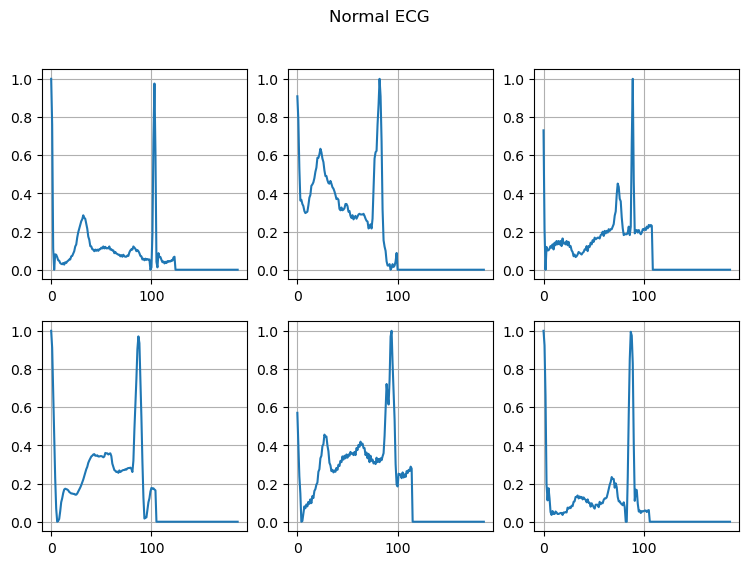

In [15]:
normal_X_test = X_test[Y_test == 0]

fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(9,6))
fig.suptitle("Normal ECG")
ax = ax.ravel()
for idx, ax in enumerate(ax):
    ax.grid()
    ax.plot(np.arange(len(normal_X_test[idx])), normal_X_test[idx])
plt.show()

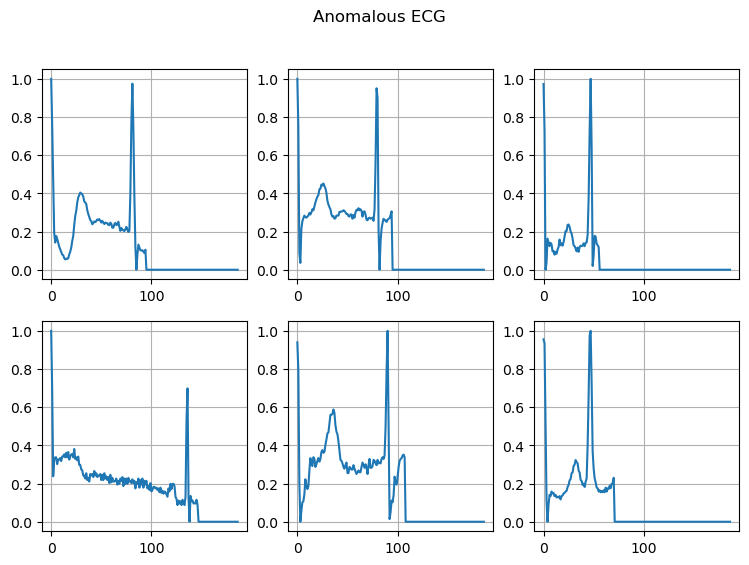

In [16]:
anomalous_X_test = X_test[Y_test!=0]

fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(9,6))
fig.suptitle("Anomalous ECG")
ax = ax.ravel()
for idx, ax in enumerate(ax):
    ax.grid()
    ax.plot(np.arange(len(anomalous_X_test[idx])), anomalous_X_test[idx])
plt.show()

test_acc = evalute(model, test_loader, criterion)
print('test acc:', test_acc)

In [17]:
batch_size = 1000
iteration = 10
criterion = nn.CrossEntropyLoss()

In [18]:
starter = torch.cuda.Event(enable_timing=True)
ender = torch.cuda.Event(enable_timing=True)
timings=np.zeros((iteration,1))

In [19]:
best_acc, best_epoch = 0, 0
test_acc=[]
test_loss=[]
with torch.no_grad(): # Gradient 연산 비활성화
    for _ in range(iteration):
        starter.record()
        
        correct = 0
        total = 0
    
        test_bar = tqdm(test_loader, file=sys.stdout)
        for step, (x, y) in enumerate(test_bar):
            x, y = x.to(device), y.to(device)
            logits_test = model(x)
            loss = criterion(logits_test, y)
            preds = logits_test.argmax(dim=1)
            correct += torch.eq(preds, y).sum().item()
            total += y.size(0)
            
            test_bar.desc = "test iteration[{}/{}] loss:{:.3f}".format(_ + 1,
                                                                     iteration,
                                                                     loss)
        
        accuracy = correct / total
        test_acc.append(accuracy)  # append를 사용하여 정확도를 리스트에 추가
        
        ender.record()
        torch.cuda.synchronize() # Gpu 연산이 완료될 때까지 대기

average_acc = sum(test_acc) / iteration  # sum 함수와 iteration으로 나누어 평균 계산
print(f"Average Test Accuracy: {average_acc * 100:.2f}%")

infer_time = starter.elapsed_time(ender)
print("Elapsed time: {} s".format(infer_time * 1e-3)) # milliseconds to second

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

Average Test Accuracy: 98.33%
Elapsed time: 0.17821836853027345 s


# Record

In [20]:
results = [train_acc, train_loss, val_acc, val_loss]
for i in range(len(results[1])):  # Assuming results[1] refers to train_loss
    results[1][i] = results[1][i].item()
for i in range(len(results[3])):
    results[3][i]=results[3][i].item()

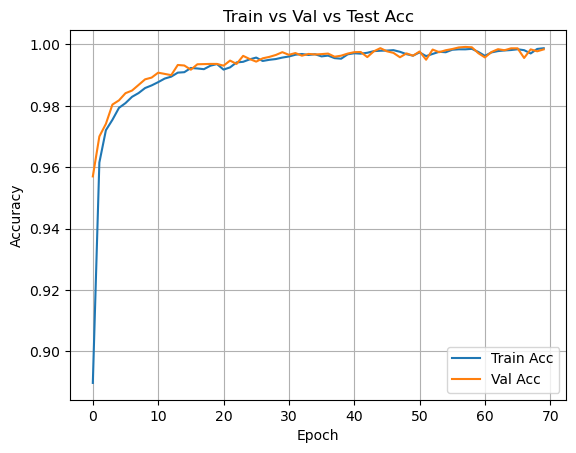

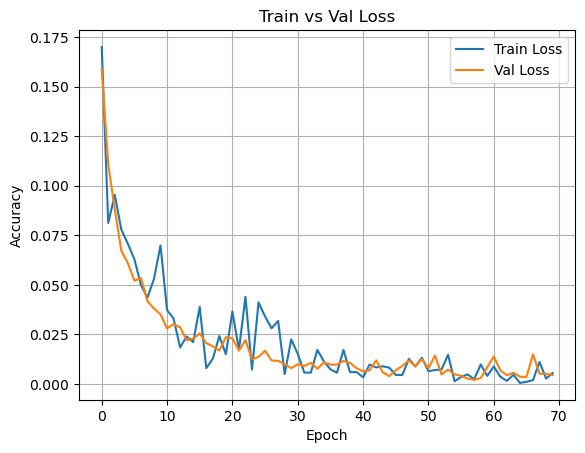

In [21]:
plt.plot(results[0])
plt.plot(results[2])
plt.legend(['Train Acc', 'Val Acc', 'Test Acc'])
plt.title('Train vs Val vs Test Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid()
plt.show()
plt.plot(results[1])
plt.plot(results[3])
plt.legend(['Train Loss', 'Val Loss'])
plt.title('Train vs Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid()
plt.show()

In [22]:
print(model)

ConvNet1D(
  (layer1): Sequential(
    (0): Conv1d(1, 16, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv1d(16, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Linear(in_features=2944, out_features=500, bias=True)
    (1): LeakyReLU(negative_slope=0.01, inplace=True)
    (2): Linear(in_features=500, out_features=5, bias=True)
  )
)


In [23]:
summary(model, input_size=(1, 187))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1              [-1, 16, 187]              64
         MaxPool1d-2               [-1, 16, 93]               0
            Conv1d-3               [-1, 64, 93]           3,136
         MaxPool1d-4               [-1, 64, 46]               0
            Conv1d-5              [-1, 128, 46]          24,704
         MaxPool1d-6              [-1, 128, 23]               0
            Linear-7                  [-1, 500]       1,472,500
         LeakyReLU-8                  [-1, 500]               0
            Linear-9                    [-1, 5]           2,505
Total params: 1,502,909
Trainable params: 1,502,909
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.18
Params size (MB): 5.73
Estimated Total Size (MB): 5.91
---------------------------------------

In [24]:
print(os.system('dot -V'))

0


dot - graphviz version 2.50.0 (0)


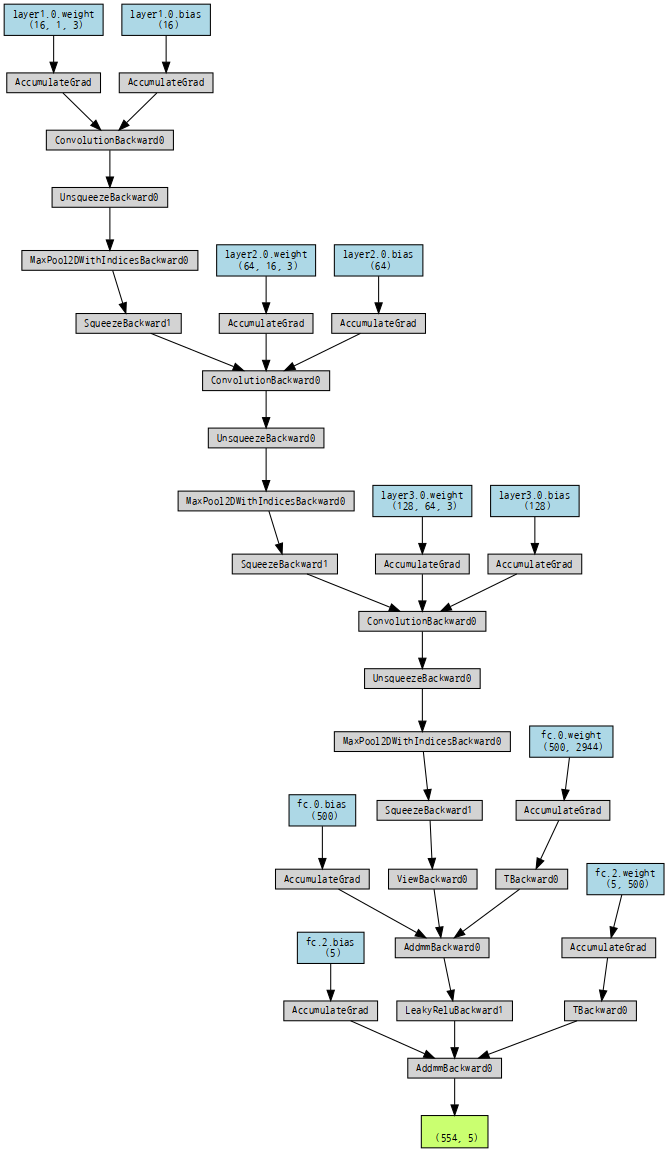

In [25]:
make_dot(logits, params=dict(list(model.named_parameters()))).render("1DCNN", format="png")
Image(filename='1DCNN.png')

In [26]:
for name, child in model.named_children():
    for param in child.parameters():
        print(name, param)

layer1 Parameter containing:
tensor([[[ 0.3775,  0.0240, -0.5007]],

        [[ 0.2932, -0.6972, -0.1318]],

        [[ 0.2444,  0.6244, -0.5919]],

        [[ 0.6436, -0.2987, -0.3904]],

        [[ 0.3558,  0.5330, -0.7226]],

        [[ 0.1767, -0.1278,  0.1755]],

        [[-0.1230,  0.6475, -0.4938]],

        [[ 0.4554, -0.5267,  0.3079]],

        [[ 0.0796,  0.1153, -0.2961]],

        [[-0.1519,  0.3485, -0.4992]],

        [[-0.4339, -0.0095,  0.3272]],

        [[ 0.0778, -0.0371, -0.0999]],

        [[-0.6289, -0.4209,  0.3207]],

        [[-0.2164,  0.5653, -0.1646]],

        [[-0.2055, -0.7248,  0.5468]],

        [[-0.5917,  0.7337, -0.4404]]], device='cuda:0', requires_grad=True)
layer1 Parameter containing:
tensor([-0.0072,  0.0605, -0.1174, -0.0106, -0.0383,  0.0015, -0.0252, -0.0721,
         0.0310,  0.0329,  0.0751, -0.0038,  0.1089, -0.0607,  0.0626,  0.0932],
       device='cuda:0', requires_grad=True)
layer2 Parameter containing:
tensor([[[-0.0593,  0.2212, -0.